In [165]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from scipy.stats import gaussian_kde
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Dense, Dropout, Activation
import pandas as pd
from matplotlib import pyplot as plt
from keras.optimizers import RMSprop
from keras.utils import np_utils

%matplotlib inline

In [86]:
# Plot the observed values versus predicted using density plot
def density_plot(x, y):
    ''' x = observed, y = predicted '''
    x = x[(~np.isnan(x)) & (~np.isnan(y))]
    y = y[(~np.isnan(x)) & (~np.isnan(y))]

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # formatting
    plt.figure(figsize=[15, 10])
    plt.scatter(x, y, c=z, s=3, edgecolor='', cmap='viridis_r')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Observed brightness')
    plt.ylabel('Predicted brightness')
    plt.title(chunk)
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    labelbottom="on", left="off", right="off", labelleft="on")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_color('gray')
    plt.gca().spines["left"].set_color('gray')
    plt.gca().xaxis.grid(True)
    plt.gca().yaxis.grid(True)

In [177]:
chunk = 'S7'

In [178]:
input_file = '/Users/katya/Lab/CRG/Research/HIS_AWS/data/' + chunk + '.txt'

data = pd.read_table(input_file)[:10000]

In [179]:
data.mut_list = data.mut_list.fillna('')
unique_mutations = set(':'.join(data.mut_list).split(':'))
unique_mutations = sorted(list(unique_mutations))
if '' in unique_mutations:
    unique_mutations.remove('')
    
data = data.reindex(np.random.permutation(data.index))
nn_genotypes_values = np.zeros((len(data), len(unique_mutations)))
nn_brightness_values = data.fitness.values

In [180]:
for i in range(len(unique_mutations)):
    nn_genotypes_values[:, i] = data.mut_list.str.contains(unique_mutations[i]).astype(np.float32)

nn_brightness_values = (nn_brightness_values - min(nn_brightness_values)) / max(
    nn_brightness_values - min(nn_brightness_values))

In [191]:
model = Sequential()

model.add(Dense(1, input_dim=nn_genotypes_values.shape[1], activation='sigmoid'))
# model.add(Dense(512, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='mean_squared_logarithmic_error',
              metrics=['accuracy'])

data = nn_genotypes_values
labels = nn_brightness_values

model.summary()


# train the model, iterating on the data in batches
# of 32 samples
model.fit(data, labels, nb_epoch=500, batch_size=500)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 1)                 140       
Total params: 140.0
Trainable params: 140
Non-trainable params: 0.0
_________________________________________________________________
Epoch 1/500
10000/10000 [==============================] - 0s - loss: 0.0758 - acc: 0.0421     
Epoch 2/500
10000/10000 [==============================] - 0s - loss: 0.0753 - acc: 0.0448     
Epoch 3/500
10000/10000 [==============================] - 0s - loss: 0.0747 - acc: 0.0460     
Epoch 4/500
10000/10000 [==============================] - 0s - loss: 0.0742 - acc: 0.0487     
Epoch 5/500
10000/10000 [==============================] - 0s - loss: 0.0737 - acc: 0.0501     
Epoch 6/500
10000/10000 [==============================] - 0s - loss: 0.0732 - acc: 0.0529     
Epoch 7/500
10000/10000 [==============================] - 0s - loss: 0.0727 - acc: 0.0554  

In [192]:
proba = model.predict_proba(data, batch_size=32)

 8352/10000 [========================>.....] - ETA: 0s

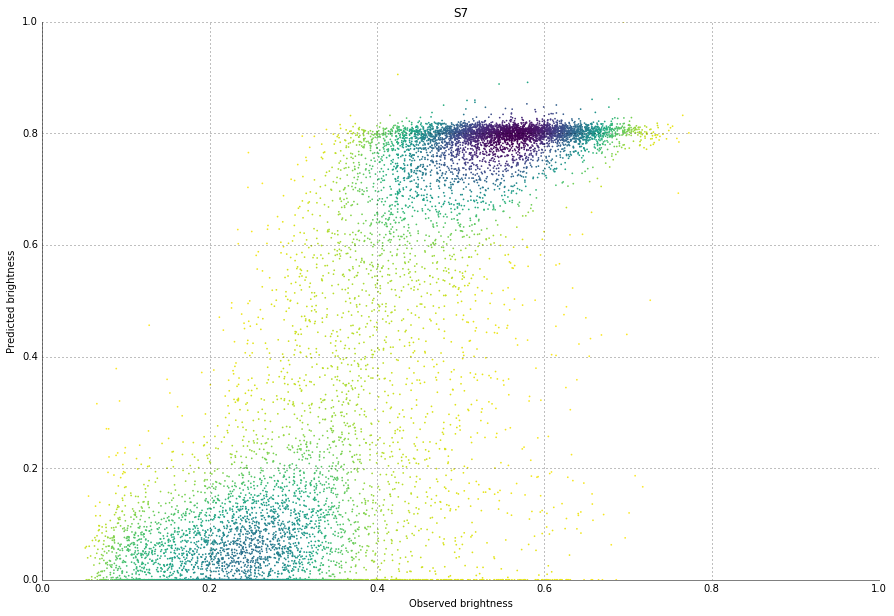

In [193]:
density_plot(proba.flatten(),labels)